In [192]:
from states.utils import apply_die_cutting, load_data, estimate_time, save_figure, load_dies
from random_question import create_board_dict
import numpy as np
import json
import bisect


In [193]:
def count_differences_np(arr1, arr2):
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    if arr1.shape != arr2.shape:
        raise ValueError("Hai ma trận phải có cùng kích thước")
    differences = np.sum(arr1 != arr2)
    return differences

In [244]:
id = 66
data = load_data(id)
board = data['board'].copy()
goal = data['goal'].copy()
dies = data['dies']

In [245]:
np.sum(board!=goal) 

773

In [280]:
k=32
sub_matrix = board[:,0:k]
sub_matrix_goal = goal[:,0:k]
counts1 = {i: np.sum(sub_matrix == i) for i in range(4)}
counts2 = {i: np.sum(sub_matrix_goal == i) for i in range(4)}
counts1 == counts2

True

In [283]:
64*64 - 0.3*1/3*64*64

3686.4

In [241]:
import numpy as np
from scipy.ndimage import label

def find_corners_numpy(matrix1, matrix2):
    matrix1 = np.array(matrix1)
    matrix2 = np.array(matrix2)
    
    diff = matrix1 != matrix2
    if not np.any(diff):  return None

    labeled, num_features = label(diff)
    corners = []
    
    for i in range(1, num_features + 1):
        indices = np.argwhere(labeled == i)
        
        top = np.min(indices[:, 0]) 
        bottom = np.max(indices[:, 0])  
        left = np.min(indices[:, 1])  
        right = np.max(indices[:, 1])
        
        new_corners = [top, left, bottom, right]
        
        overlap = False
        for corner in corners:
            prev_top, prev_left, prev_bottom, prev_right = corner
            if not (right < prev_left or left > prev_right or bottom < prev_top or top > prev_bottom):
                overlap = True
                break
        
        if not overlap: corners.append(new_corners)
    
    return corners
find_corners_numpy(board, goal)


[[3, 0, 31, 31]]

In [191]:
def sol_3(h, w, board, goal, dies): # 2 die 2 moves dựa trên ngưỡng
    max_score = np.sum(board!=goal)
    results= []
    top, left, _, _ = find_corners_numpy(board, goal)[0]
    for x in range(left, w):
        for y in range(top, h):
            for d in [0,2,3]:
                for id, die in enumerate(dies):
                    new_state = apply_die_cutting(board, die, x, y, d)
                    score = np.sum(new_state!=goal)
                    if (score-max_score)/max_score <= -0.6: 
                        results.append((id, x, y, d))
                        top2, left2, _, _ = find_corners_numpy(new_state, goal)[0]
                        for x2 in range(left2, w):
                            for y2 in range(top2, h):
                                for d2 in [3,2]:
                                    for id2, die2 in enumerate(dies):
                                        new_state2 = apply_die_cutting(new_state, die2, x2, y2, d2)
                                        score2 = np.sum(new_state2!=goal)
                                        if score2==0:
                                            results.append((id2, x2, y2, d2))
                                            return results
                                    
    return results


In [322]:
def check_type(sub_matrix, sub_matrix_goal):
    lst_col = []
    lst_row = []
    x_start = 0
    y_start = 0
    for i in range(len(sub_matrix[0])):
        if sub_matrix[1][i] != sub_matrix_goal[1][i]:
            x_start = i
            break
    for i in range(len(sub_matrix)):
        if sub_matrix[i][0] != sub_matrix_goal[i][0]:
            y_start = i
            break
    # for ci in range(x_start, len(sub_matrix[0])):
    #     col_goal_ci = sub_matrix_goal[:,ci]
    #     for cj in range(sub_matrix.shape[1]):
    #         if np.array_equal(sub_matrix[:,cj], col_goal_ci):
    #             lst_col.append(cj)
    for ci in range(x_start, len(sub_matrix[0])):
        lst_col.extend([cj for cj in range(sub_matrix.shape[1]) if np.array_equal(sub_matrix[:, cj], sub_matrix_goal[:, ci])])
    # for ri in range(y_start,len(sub_matrix) ):
    #     row_goal_ri = sub_matrix_goal[ri]
    #     for rj in range(sub_matrix.shape[0]):
    #         if np.array_equal(sub_matrix[rj], row_goal_ri):
    #             lst_row.append(rj)
    for ri in range(y_start, len(sub_matrix)):
        lst_row.extend([rj for rj in range(sub_matrix.shape[0]) if np.array_equal(sub_matrix[rj], sub_matrix_goal[ri])])
    for i in range(len(lst_col)-1):
        if lst_col[i+1] == lst_col[i]+2: 
            return [3, min(lst_col)]
        elif lst_col[i+1] == lst_col[i] +1: 
            return [1, min(lst_col)]
        return 0
    print(lst_row)
    for j in range(len(lst_row)-1):
        if lst_row[j+1] == lst_row[j]+2: 
            return [2, min(lst_row)]
def sol_corner(board, goal):
    corners = find_corners_numpy(board, goal) # sửa cái này lấy vùng liên thông lớn nhất
    w_board = len(board[0])
    results = []
    for i in corners:
        top, left, bottom, right = i
        die_id = max(bottom-top, right-left)
        die_size = [1, 2, 4, 8, 16, 32, 64, 128, 256]
        die_=[die_size[bisect.bisect_right(die_size, die_id) - 1],  die_size[bisect.bisect_left(die_size, die_id)]]
        sub_matrix = board[top:bottom+1, left:right+1]
        sub_matrix_goal = goal[top:bottom+1, left:right+1]
        counts1 = {i: np.sum(sub_matrix == i) for i in range(4)}
        counts2 = {i: np.sum(sub_matrix_goal == i) for i in range(4)}
        if counts1 == counts2:  
            type_die = check_type(sub_matrix, sub_matrix_goal)[0]
            start_x = check_type(sub_matrix, sub_matrix_goal)[1]
            if type_die == 1:
                for d in [1,2,3]:
                    for matrix_id in die_:
                        state= apply_die_cutting(sub_matrix, dies[die_size.index(matrix_id)*3-2], start_x, 0, d)
                        if np.all(state == sub_matrix_goal):  
                            results.append(( die_size.index(matrix_id)*3-2,  start_x+left , top, d))
            elif type_die ==3:
                for d in [1,2,3]:
                    for matrix_id in die_:
                        if left >= w_board//2:
                            state= apply_die_cutting(sub_matrix, dies[die_size.index(matrix_id)*3], start_x-1 , 0, d)
                            if np.all(state == sub_matrix_goal): results.append(( die_size.index(matrix_id)*3,  start_x+left-1 , top, d))
                        else:    
                            state= apply_die_cutting(sub_matrix, dies[die_size.index(matrix_id)*3], start_x , 0, d)
                            w_die = len(dies[die_size.index(matrix_id)*3]) + start_x
                            if np.all(state == sub_matrix_goal) and w_die <= w_board: results.append(( die_size.index(matrix_id)*3,  start_x , top, d))
            else: pass # trường hợp 2
    return {
        "n": len(results),
        "ops": [{"p": re[0], "x": re[1], "y": re[2], "s": re[3]} for re in results]
    }

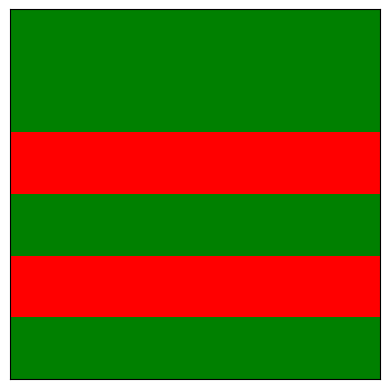

In [323]:
a = np.array([[1,2,3,1,2,1], [1,2,3,2,1,1], [0,0,1,1,2,3], [0,1,0,2,3,1], [0,0,2,2,3,1], [2,2,3,3,1,1]])
b = apply_die_cutting(a, dies[8], 2, 2, 3)
save_figure(1, a, b, True)

In [324]:
check_type(a, b)

[3, 5]


[2, 3]

In [309]:
a, b

(array([[1, 2, 3, 1, 2, 1],
        [1, 2, 3, 2, 1, 1],
        [0, 0, 1, 1, 2, 3],
        [0, 1, 0, 2, 3, 1],
        [0, 0, 2, 2, 3, 1],
        [2, 2, 3, 3, 1, 1]]),
 array([[1, 2, 3, 1, 2, 1],
        [1, 2, 3, 2, 1, 1],
        [1, 1, 2, 3, 0, 0],
        [0, 1, 0, 2, 3, 1],
        [2, 2, 3, 1, 0, 0],
        [2, 2, 3, 3, 1, 1]]))